# 2D SLAM with Bayes3D renderer -- Hierarchical Sensor

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bayes3d as b3d
import bayes3d.genjax
import genjax
from genjax import gen
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import jax.tree_util as jtu
import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import Diff
import trimesh
import pythreejs as p3s

def more_keys(key, n=1):
    keys = jax.random.split(key,n)
    if n == 1: return keys[0]
    return keys

def rot2d(hd): return jnp.array([
    [jnp.cos(hd), -jnp.sin(hd)], 
    [jnp.sin(hd),  jnp.cos(hd)]
    ])

def pack_2dpose(x,hd): return jnp.concatenate([x,jnp.array([hd])])

def apply_2dpose(p, ys): 
    return ys@rot2d(p[2] - jnp.pi/2).T + p[:2]

def unit_vec(hd): return jnp.array([jnp.cos(hd), jnp.sin(hd)])

def morekeys(key, n=1):
    if n==1: return jax.random.split(key, 1)[0]
    else: return jax.random.split(key, n)

key = jax.random.PRNGKey(0)
console = genjax.pretty(show_locals=False)

In [3]:
def adjust_angle(hd): return (hd + jnp.pi)%(2*jnp.pi) - jnp.pi

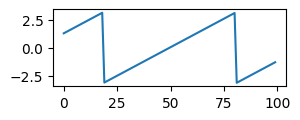

In [6]:
# ---------------------------
plt.figure(figsize=(3,1))
plt.plot([adjust_angle(x) for x in jnp.linspace(-5,5, 100)]);

In [7]:
# 
# Monkey patching `sample` for `BuiltinGenerativeFunction`
# 
cls = genjax._src.generative_functions.builtin.builtin_gen_fn.BuiltinGenerativeFunction

def genjax_sample(self, key, *args, **kwargs):
    _, tr = self.simulate(key, args)
    return tr.get_retval()

setattr(cls, "sample", genjax_sample)


# 
# Monkey patching `sample` for `DeferredGenerativeFunctionCall`
# 
cls = genjax._src.generative_functions.builtin.builtin_gen_fn.DeferredGenerativeFunctionCall

def deff_gen_func_call(self, key, **kwargs):
    return self.gen_fn.sample(key, *self.args, **kwargs)

def deff_gen_func_logpdf(self, x, **kwargs):
    return self.gen_fn.logpdf(x, *self.args, **kwargs)

setattr(cls, "__call__", deff_gen_func_call)
setattr(cls, "logpdf", deff_gen_func_logpdf)

In [8]:
from bayes3d._mkl.pose import pack_pose, unpack_pose, apply_pose, lift_pose, from_euler, look_at
from bayes3d._mkl.meshes import *
from bayes3d._mkl.plotting import *
from bayes3d._mkl.raycast import cast, jcast, create_angles
import numpy as np

Load 2d data and lift to 3d...

In [9]:
fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T = len(_xs)


def bounding_box(arr, pad=0):
    """Takes a point-like (last dim = 2) arr and returns its bounding box."""
    return jnp.array([
        [jnp.min(arr[...,0])-pad, jnp.min(arr[...,1])-pad],
        [jnp.max(arr[...,0])+pad, jnp.max(arr[...,1])+pad]
    ])
_bb = bounding_box(_segs)


_ps = np.concatenate([_xs, _hds[:,None]], axis=1)

_boxes[0], _T

(array([ 7.1517381 , 17.62209524,  7.8517381 , 17.62209524]), 50)

In [10]:
box_mesh = trimesh.util.concatenate([trimesh_from_2d_segs(box) for box in _boxes.reshape(-1,4,4)])
map_mesh = trimesh_from_2d_segs(_segs)
table = create_cuboid(20, 20, -0.1)
table = move_to_xy(table, *_center)

map_mesh.vertices[:,2] -= 0.5
box_mesh.vertices[:,2] -= 0.5
table.vertices[:,2] -= 0.5

In [10]:
v = Viewer(width=800, cam_pos=(*_center,15), cam_look=np.array([*_center,0]), background="#eee", view_as="world")
v.add_mesh(map_mesh.vertices, map_mesh.faces, c=np.array([.99,.99,.99]))
v.add_mesh(box_mesh.vertices, box_mesh.faces, c=np.array([.99,.1,.1]))
v.add_mesh(table.vertices, table.faces, c=np.array([1.,1.,1.]))
for p in jax.vmap(lift_pose)(_xs, _hds): v.add_pose(p, scale=0.5, width=2)

v

Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.6, positio…

Initialize and set up the 3D renderer and see if it works. Then restrict image height to 1 mimicing a lidar sensor.

Camera projection is given by 
$$
\begin{pmatrix}
f_x & 0   & c_x \\ 
0   & f_y & c_y \\ 
0   & 0   & 1   \\ 
\end{pmatrix}
$$

TODO: `near` should show up somewhere

## Set up the renderer

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 32, 1024)
['object_0', 'object_1']


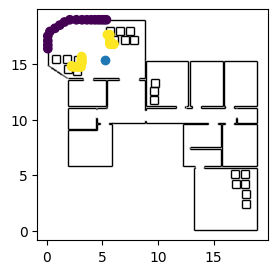

In [11]:
w = 50
h = 1

near = .01
far  = 10.0

fx = 10
fy = 10

cx = w/2 - 0.5
cy = h/2 - 0.5

intrinsics = b3d.Intrinsics(
    height = h,
    width  = w,
    fx=fx, fy=fy,
    cx=cx, cy=cy,
    near=near, far=far
)
b3d.setup_renderer(intrinsics)
b3d.RENDERER.add_mesh(trimesh.util.concatenate([map_mesh, table]), center_mesh=False)
b3d.RENDERER.add_mesh(box_mesh, center_mesh=False)

def render(p, inds=[0,1]):
    p_ = b3d.t3d.inverse_pose(p)
    return b3d.RENDERER.render(jnp.tile(p_, (len(inds),1,1)), jnp.array(inds))

print(b3d.RENDERER.mesh_names)

t = 40
p = _ps[t]
X = render(lift_pose(p[:2], p[2]), inds=[0,1])
xs = X[0,:,[0,2]].T
xs = apply_2dpose(p, xs)


# -----------------
plt.figure(figsize=(3,3))
plt.gca().set_aspect(1)
plot_segs(plt.gca(),_segs, c="k", zorder=-1)
plot_segs(plt.gca(),_boxes, c="k", zorder=-1)
plt.scatter(*_ps[t][:2], marker="o")
plt.scatter(*xs.T,c=X[0,:,3], vmin=1, vmax=2)

## Define the model

In [12]:
from genjax.generative_functions.distributions import ExactDensity
from bayes3d._mkl.likelihood import constrained_lh, constrained_lh_jit, pad_jit
from bayes3d.likelihood import threedp3_likelihood
from functools import partial 
from jax import jit

from genjax import tfp_uniform as uniform, choice_map

?threedp3_likelihood

Signature:
threedp3_likelihood(
    observed_xyz: jax.Array,
    rendered_xyz: jax.Array,
    variance,
    outlier_prob,
    outlier_volume,
    filter_size,
)
Docstring: <no docstring>
File:      ~/workspace/bayes3d/bayes3d/likelihood.py
Type:      function

In [13]:
def make_img_dist(w:int, zmax:float):

    class B3DImageDist(ExactDensity):
        def sample(self, key, Y, sig, outlier):
            # TODO: write this method
            return Y

        def logpdf(self, X, Y, sig, outlier):
            return threedp3_likelihood(X,Y, sig**2, outlier, 10.0, w)
            # return constrained_lh(X, Y, zmax, sig, outlier, w)
        
    return B3DImageDist()

In [14]:
def make_model(w:int, zmax:float):

    # TODO: Note that we shouldn't have to do this! 
    # There is an underlying bug. Ask McCoy if the issue got resolved yet.
    b3d_img_dist = make_img_dist(w, zmax)
    
    @gen
    def model(inds):

        x  = uniform(jnp.array([-20.,-20.]), jnp.array([20.,20.])) @ "x"
        hd = uniform(-jnp.pi, jnp.pi) @ "hd"
        
        # Lift pose to 3D and 
        # render an image
        Y = render(lift_pose(x,hd), inds)

        # Sample Hyper Parameters
        sig     = uniform(0.001, 1.) @ "sig"
        outlier = uniform(0.001, 1.) @ "outlier"

        X = b3d_img_dist(Y, sig, outlier) @ "image"

        return pack_2dpose(x, hd), X[0,:,[0,2]].T
    
    return model


In [15]:
def argdiffs(args): return (tuple(map(lambda v: Diff(v, UnknownChange), args)))

In [30]:
"""Create Groundtruth observations with Boxes"""
t = 40
# t = 2

zmax    = 100.0
sig     = 0.1
outlier = 0.1
w       = 7

model = make_model(w, zmax)
ch = choice_map({
        "x":  _xs[t],
        "hd": _hds[t],
        "sig": sig,
        "outlier": outlier,
})
model_args = (jnp.array([0,1]),)


# Create Groundtruth trace -- to get observations, we are 
# going to perturb the correct pose later.
key,(_,tr0) = model.importance(key, ch, model_args)

print(f"Score with clutterd map:  {tr0.get_score():>10.2f}")

# We created the observation WITH the boxes, but for inference
# we are going to ignore them, assuming we only have access
# to an indealized map, so we have to change the args...
ch    = choice_map({})
diffs = (Diff(jnp.array([0]), UnknownChange),)
key, (_, w, tr0, _) = tr0.update(key, ch, diffs)

print(f"Score with idealized map: {tr0.get_score():>10.2f} (should be lower)")

Score with clutterd map:      -41.95
Score with idealized map:    -180.07 (should be lower)


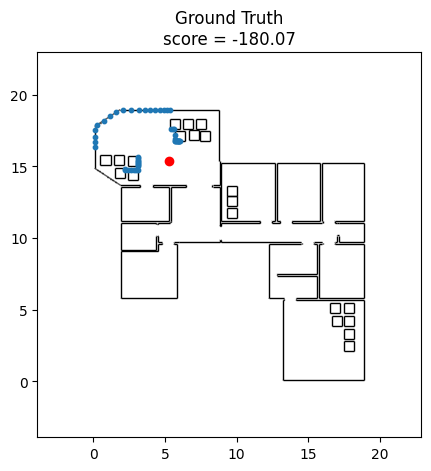

In [31]:
_segs  = _segs.reshape(-1,2,2)
_boxes = _boxes.reshape(-1,2,2)

def plot_tr(tr, ax=None, title=""):
    
    if ax is None:
        plt.figure(figsize=(5,5))
        ax=plt.gca()

    p, xs = tr.get_retval()

    # ---------------------
    
    if len(title) > 0: title = f"{title}\n"
    ax.set_title(f"{title}score = {tr.get_score():0.2f}")
    ax.set_aspect(1)
    PAD = 4
    ax.set_xlim(*bounding_box(_segs, pad=PAD)[:,0])
    ax.set_ylim(*bounding_box(_segs, pad=PAD)[:,1])
    plot_segs(ax, _segs, c="k", zorder=1)
    plot_segs(ax, _boxes, c="k", zorder=1)
    ax.scatter(*p[:2], c="r", zorder=2)
    ax.scatter(*apply_2dpose(p, xs).T, s=10, zorder=2)


plot_tr(tr0, None, title="Ground Truth")


## Inference

In [32]:
def _eval_pose(tr, key, p, sig, outlier):
    ch    = choice_map({
        'x': p[:2], 
        'hd':p[2],
        'sig': sig,
        'outlier': outlier,
        })
    diffs = argdiffs(tr.args)

    key, (_, w, tr_, _) = tr.update(key, ch, diffs)
    return tr_.get_score()

eval_poses = jax.jit(jax.vmap(_eval_pose, in_axes=(None, None, 0, None, None)))

In [33]:
def _eval_pose_and_sensor(tr, key, p, sig, outlier):
    ch    = choice_map({
        'x': p[:2], 
        'hd':p[2],
        'sig': sig,
        'outlier': outlier,
        })
    diffs = argdiffs(tr.args)
    key, (_, w, tr_, _) = tr.update(key, ch, diffs)
    return tr_.get_score()

eval_pose_and_sensor = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, 0, 0)))

In [34]:
def vector_grid(v0, shape, r, flat=False):
    r = jnp.array(r)
    vs = np.stack(jnp.indices(shape), axis=-1).reshape(-1,len(shape))
    vs = r[None]*vs
    center = (vs[0] + vs[-1])/2
    vs = vs - center + v0
    if flat: 
        return vs
    else: 
        return vs.reshape(shape)

In [35]:
@gen
def anchored_pose_prior(p, sig_x=0.5, sig_hd=10):
    
    sig_hd = sig_hd/180*jnp.pi

    x  = genjax.tfp_normal(p[:2], sig_x*jnp.ones(2)) @ "x"
    hd = genjax.tfp_normal(p[2], sig_hd) @ "hd"
    
    return pack_2dpose(x, adjust_angle(hd))

### Perturbing trace

TODO:
- This proposal has a different address structure due to the choice of `i`. Need to write a trace translator to correct for that.

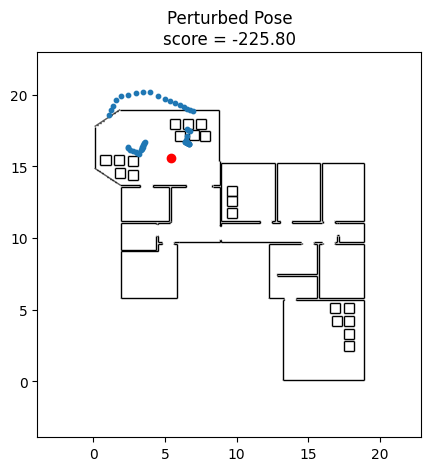

In [36]:
# Get true pose and observations
p0, xs = tr0.get_retval()

# Perturbed pose
key = more_keys(key)
q_ = anchored_pose_prior(p0, .25, 15)(key)

# Compromise the trace
ch    = choice_map({'x':q_[:2], 'hd':q_[2]})
diffs = argdiffs(tr0.args)
tr = tr0.update(key, ch, diffs)[1][2]

plot_tr(tr, title="Perturbed Pose")

In [361]:
logsumexp = jax.scipy.special.logsumexp

In [362]:
def argmax_axes(a, axes=None):
    if axes is None: return jnp.argmax(a)
    
    n = len(axes)        
    axes_  = set(range(a.ndim))
    axes_0 = axes
    axes_1 = sorted(axes_ - set(axes_0))    
    axes_  = axes_0 + axes_1

    b = jnp.transpose(a, axes=axes_)
    c = b.reshape(np.prod(b.shape[:n]), -1)

    I = jnp.argmax(c, axis=0)
    I = jnp.array([jnp.unravel_index(i, b.shape[:n]) for i in I]).reshape(b.shape[n:] + (n,))

    return  I


test_shape = (3, 99, 5, 9)
a = jnp.arange(np.prod(test_shape)).reshape(test_shape)

I = argmax_axes(a, axes=[0,1])
I.shape

(5, 9, 2)

## The grid

(61952, 5)

    min diff(grid  x, true  x) = 0.15
    min diff(grid hd, true hd) = 0.07

(8, 8, 8, 11, 11, 5)


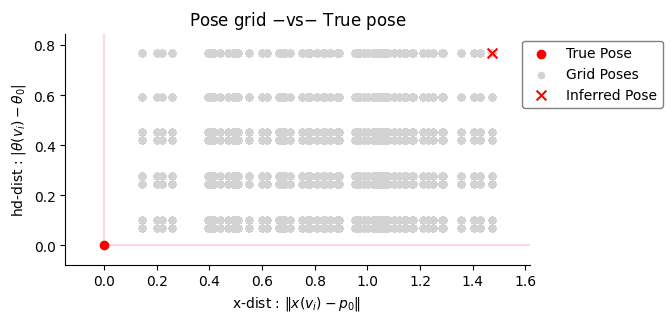

In [452]:
x0  = tr['x']
hd0 = tr['hd']


dx  = 1.
dhd = 35/180*jnp.pi

# shape = (6, 6, 6, 11, 11)
shape = (8, 8, 8, 11, 11)

vs = jnp.stack(jnp.meshgrid(
    jnp.linspace(x0[0]-dx,x0[0]+dx, shape[0]), 
    jnp.linspace(x0[1]-dx,x0[1]+dx, shape[1]), 
    jnp.linspace(hd0-dhd,hd0+dhd, shape[2]), 
    jnp.linspace(0.001, 0.5, shape[3]),  # sig
    jnp.linspace(0.001, 0.9, shape[4]), # outlier
indexing='ij'),   axis=-1).reshape(-1,5)

print(vs.shape)


xdist = jnp.linalg.norm(vs[:,:2]-p0[:2], axis=1)
hddist = jnp.abs(jax.vmap(adjust_angle)(vs[:,2]-p0[2]))



min_x_diff = jnp.min(
        jnp.linalg.norm(
            vs[:,:2]-p0[:2]
        , axis=1)
)
min_hd_diff = adjust_angle(jnp.min(jnp.abs(vs[:,2]-p0[2])))

print(f"""
    min diff(grid  x, true  x) = {min_x_diff:0.2f}
    min diff(grid hd, true hd) = {min_hd_diff:0.2f}
""")


key = morekeys(key)

sc = eval_pose_and_sensor(tr, key, vs[:,:3], vs[:,3], vs[:,4])
sc = sc - jax.scipy.special.logsumexp(sc)

vs = vs.reshape(shape+(len(shape),))
sc = sc.reshape(shape)

print(vs.shape)


def plot_dist_grid(v=None):
    # ------------------
    plt.figure(figsize=(6,3))
    plt.title("Pose grid $-$vs$-$ True pose")
    plt.xlim(-0.1*jnp.max( xdist),1.1*jnp.max( xdist))
    plt.ylim(-0.1*jnp.max(hddist),1.1*jnp.max(hddist))
    plt.xlabel("x-dist : $\| x(v_i) - p_0\|$ ")
    plt.ylabel("hd-dist : $| \\theta(v_i) - \\theta_0 |$")
    plt.vlines(0,0,1.1*jnp.max( hddist), color="r", alpha=0.15, zorder=1)
    plt.hlines(0,0,1.1*jnp.max( xdist), color="r", alpha=0.15, zorder=1)
    plt.gca().spines[['right', 'top']].set_visible(False)


    plt.scatter(0, 0, c="r", zorder=1, label="True Pose");
    plt.scatter(xdist, hddist, s=20, marker="o", zorder=2, c="lightgray", label="Grid Poses");

    if v is not None:
        v = v.reshape(-1,3)
        plt.scatter(
            jnp.linalg.norm(v[:,:2]-p0[:2], axis=1), 
            jnp.abs(jax.vmap(adjust_angle)(v[:,2]-p0[2])),
            c="r", zorder=3, marker="x", s=50, label="Inferred Pose");
    
    plt.legend(loc="upper right", edgecolor="gray", framealpha=1.0, bbox_to_anchor = (1.3, 1.))

plot_dist_grid(vs.reshape(-1,5)[0,:3])

### Overall max

(61952, 5)
(61952,)


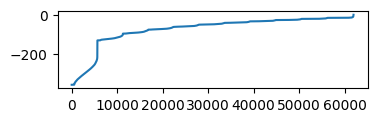

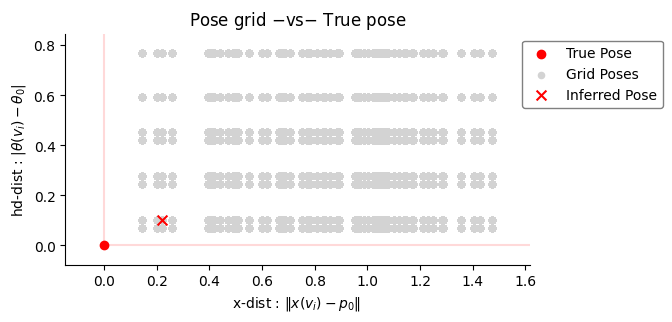

In [453]:
sc_ = sc.reshape(-1)
vs_ = vs.reshape(-1,5)

order = jnp.argsort(sc_)

print(vs_.shape)
print(sc_.shape)

# ---------------------
plt.figure(figsize=(4,1))
plt.plot(sc_[order])

# -----------------------
plot_dist_grid(vs_[order[-1],:3])

[0.001 0.9  ]


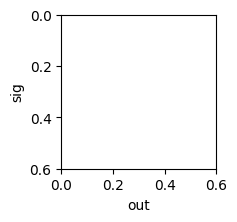

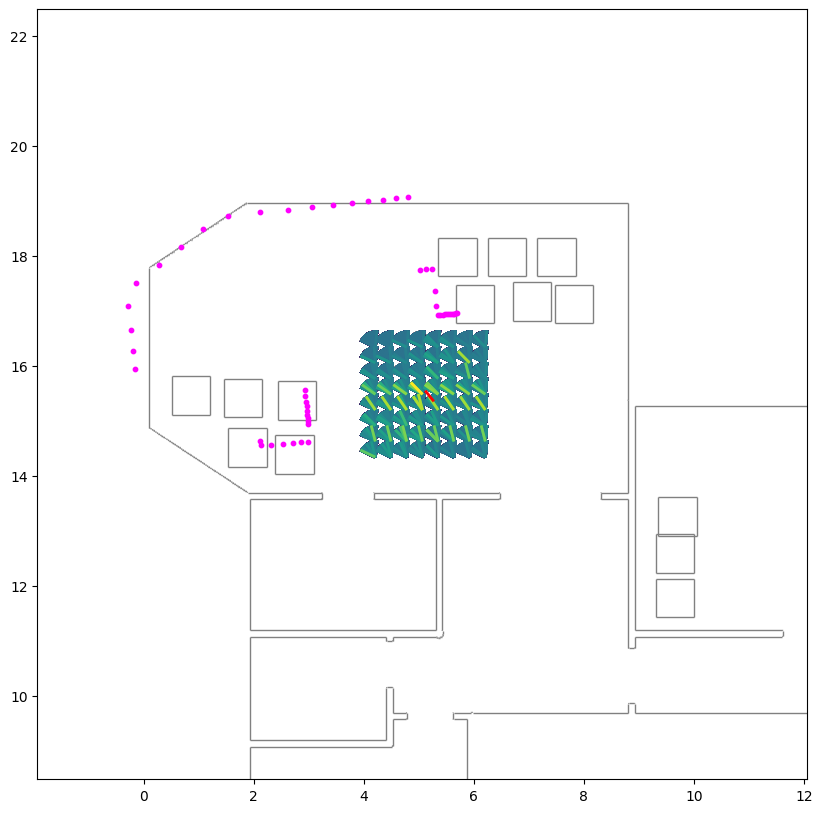

In [454]:
sc_ = jnp.clip(sc_, -1e6,  jnp.max(sc_))
sc_ = jnp.clip(sc_, jnp.quantile(sc_, 0.8), jnp.max(sc_))
cs  = plt.cm.viridis(plt.Normalize()(sc_))

i = jnp.argmax(sc_)


print(vs_[i,3:])
_,xs = tr.get_retval()
q = vs_[i,:]

a = vs_[:,:2]
b = a + 0.3*jax.vmap(unit_vec)(vs_[:,2])

seg_color = "gray"
PAD = 7

# ---------------------
plt.figure(figsize=(2,2))
plt.xlim(0,0.6)
plt.ylim(0.6, 0.0)
plt.scatter(vs_[i,4], vs_[i,3], c="r")
plt.xlabel("out")
plt.ylabel("sig")

# ---------------------
plt.figure(figsize=(10,10))
plt.gca().set_aspect(1)
zoom_in(plt.gca(), q[:2], PAD)
# zoom_in(plt.gca(), _bb, PAD)
plot_segs(plt.gca(), _segs, c=seg_color, zorder=2)
plot_segs(plt.gca(), _boxes, c=seg_color, zorder=2)
plt.scatter(*apply_2dpose(q, xs).T, s=10, c="magenta", alpha=1., zorder=3, )


plt.plot(
    *jnp.stack([p0[:2], p0[:2] + 0.2*unit_vec(p0[2])], axis=1), 
c="r", zorder=4, linewidth=2)


# plt.scatter(vs_[:,0],vs_[:,1], c="w", zorder=3, s=1, alpha=0.1)
plt.gca().add_collection(line_collection(a[order],b[order], c=cs[order], zorder=1, linewidth=2));


### Marginalize over sensor args

(512, 5)
(512,)


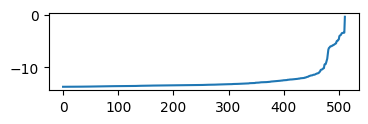

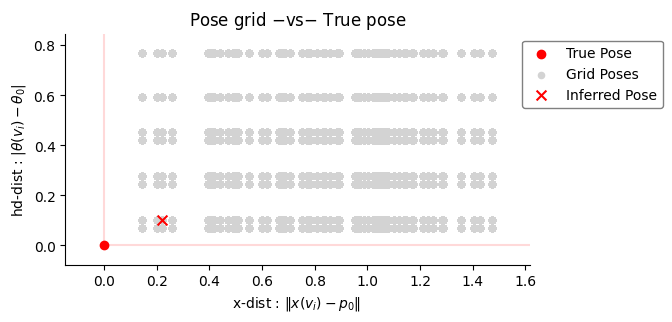

In [455]:
sc_ = logsumexp(sc, axis=(3,4)).reshape(-1)
vs_ = vs[:,:,:,0,0].reshape(-1,5)

order = jnp.argsort(sc_)

print(vs_.shape)
print(sc_.shape)

# ---------------------
plt.figure(figsize=(4,1))
plt.plot(sc_[order])

# -----------------------
plot_dist_grid(vs_[order[-1],:3])

[0.001 0.001]


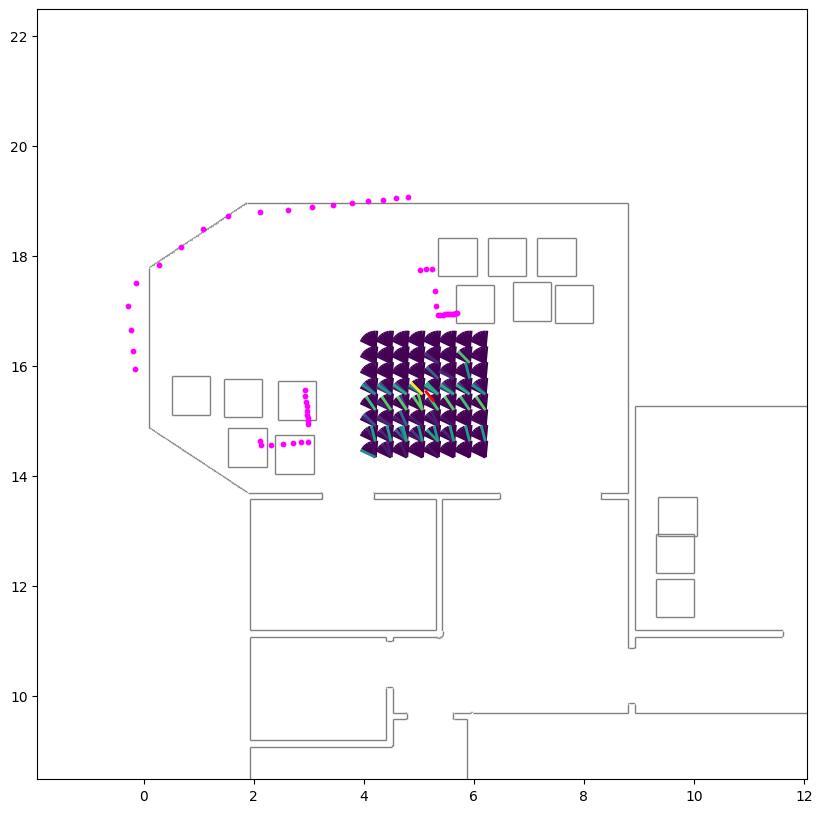

In [456]:
sc_ = jnp.clip(sc_, -1e6,  jnp.max(sc_))
sc_ = jnp.clip(sc_, jnp.quantile(sc_, 0.8), jnp.max(sc_))
cs  = plt.cm.viridis(plt.Normalize()(sc_))

i = jnp.argmax(sc_)


print(vs_[i,3:])
_,xs = tr.get_retval()
q = vs_[i,:]

a = vs_[:,:2]
b = a + 0.3*jax.vmap(unit_vec)(vs_[:,2])

seg_color = "gray"
PAD = 7

# ---------------------
plt.figure(figsize=(10,10))
plt.gca().set_aspect(1)
zoom_in(plt.gca(), q[:2], PAD)
# zoom_in(plt.gca(), _bb, PAD)
plot_segs(plt.gca(), _segs, c=seg_color, zorder=2)
plot_segs(plt.gca(), _boxes, c=seg_color, zorder=2)
plt.scatter(*apply_2dpose(q, xs).T, s=10, c="magenta", alpha=1., zorder=3, )


plt.plot(
    *jnp.stack([p0[:2], p0[:2] + 0.2*unit_vec(p0[2])], axis=1), 
c="r", zorder=4, linewidth=2)

# plt.scatter(vs_[:,0],vs_[:,1], c="w", zorder=3, s=1, alpha=0.1)
plt.gca().add_collection(line_collection(a[order],b[order], c=cs[order], zorder=1, linewidth=2));


### Max Poses conditioned on sensor params

(8, 8, 8, 11, 11)


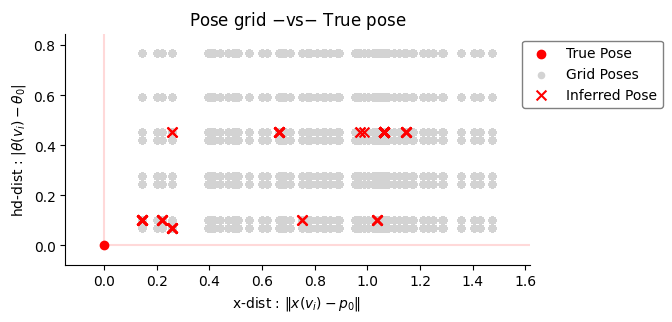

In [457]:
print(sc.shape)
I = argmax_axes(sc, axes=[0,1,2]).reshape(-1,3)

vv = vs[I.T[0],I.T[1],I.T[2],0,0,:]



# -----------------------
plot_dist_grid(vv[:,:3])

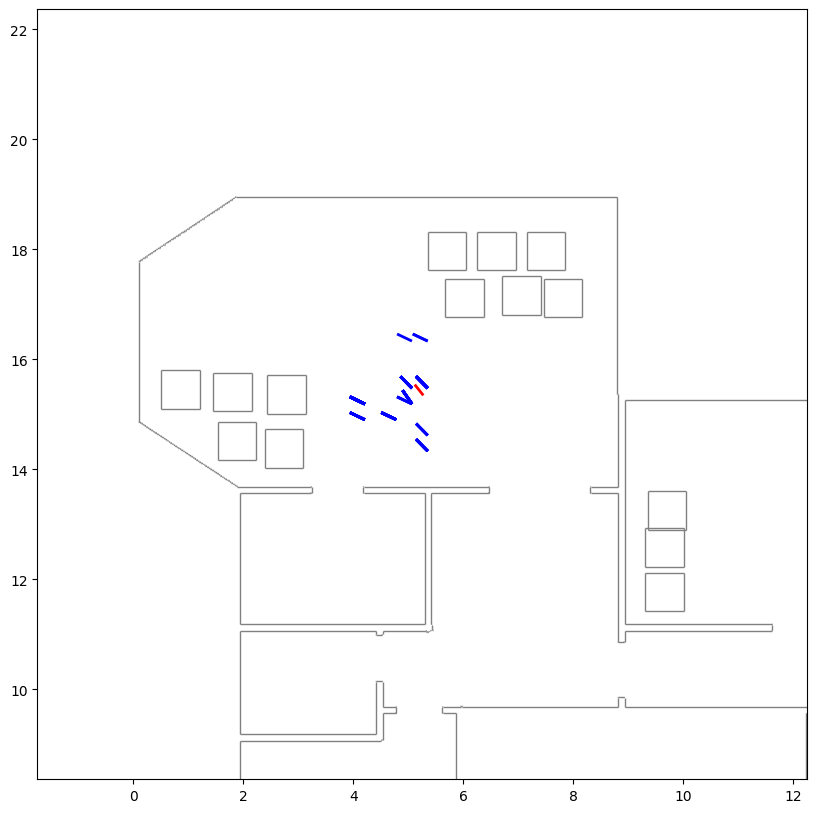

In [458]:


# ---------------------
PAD = 7
plt.figure(figsize=(10,10))
plt.gca().set_aspect(1)
plot_segs(plt.gca(), _segs, c=seg_color, zorder=2)
plot_segs(plt.gca(), _boxes, c=seg_color, zorder=2)
zoom_in(plt.gca(), p0[:2], PAD)
plt.gca().add_collection(line_collection(
    vv[:,:2],vv[:,:2] + 0.3*jax.vmap(unit_vec)(vv[:,2]), 
c="b", zorder=1, linewidth=2));

plt.plot(
    *jnp.stack([p0[:2], p0[:2] + 0.2*unit_vec(p0[2])], axis=1), 
c="r", zorder=4, linewidth=2)

### 

### Marginalize over poses

(121, 5)
(121,)


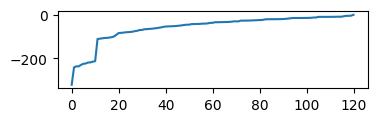

In [459]:
sc_ = logsumexp(sc, axis=(0,1,2)).reshape(-1)
vs_ = vs[0,0,0,:,:].reshape(-1,5)

order = jnp.argsort(sc_)

print(vs_.shape)
print(sc_.shape)

# ---------------------
plt.figure(figsize=(4,1))
plt.plot(sc_[order])


In [460]:
sc_ = sc_ - logsumexp(sc_)


Text(0.5, 0, 'out')

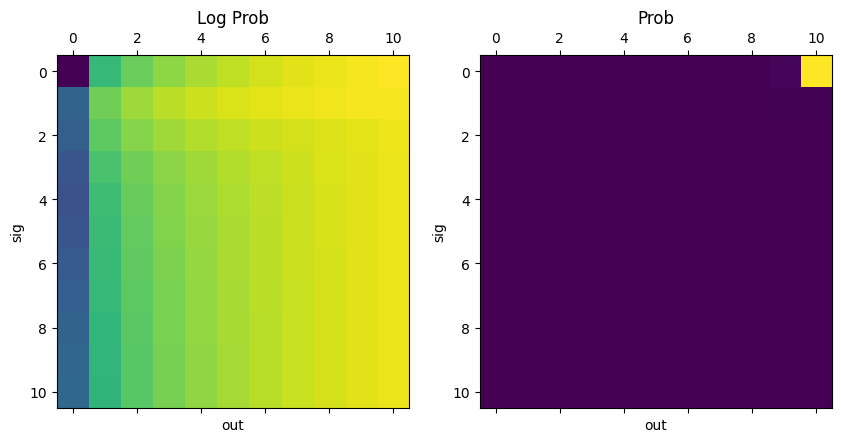

In [461]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].set_title("Log Prob")
axs[0].matshow(sc_.reshape(shape[-2:]))
axs[0].set_ylabel("sig")
axs[0].set_xlabel("out")

axs[1].set_title("Prob")
axs[1].matshow(jnp.exp(sc_).reshape(shape[-2:]))
axs[1].set_ylabel("sig")
axs[1].set_xlabel("out")